## Brand Clustering

#### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Load Dataset

In [2]:
product = pd.read_csv('Adidas Vs Nike.csv', usecols=['Product Name', 'Product ID', 'Brand', 'Description', 'Rating', 'Reviews'])
product.head(3)

,Product Name,Product ID,Brand,Description,Rating,Reviews
0,Women's adidas Originals NMD_Racer Primeknit S...,AH2430,Adidas Adidas ORIGINALS,Channeling the streamlined look of an '80s rac...,4.8,41
1,Women's adidas Originals Sleek Shoes,G27341,Adidas ORIGINALS,"A modern take on adidas sport heritage, tailor...",3.3,24
2,Women's adidas Swim Puka Slippers,CM0081,Adidas CORE / NEO,These adidas Puka slippers for women's come wi...,2.6,37


## Data Cleaning

#### Rename Columns

In [3]:
product.rename(columns={'Product Name':'name','Product ID':'id','Brand':'brand','Description':'description','Rating':'rating',
                        'Reviews':'reviews'}, inplace=True)

#### Duplicates Removal

In [4]:
product.duplicated().sum()

88

In [5]:
product.drop_duplicates(inplace=True)

#### Missing Values

In [6]:
product.isnull().sum()

name           0
id             0
brand          0
description    3
rating         0
reviews        0
dtype: int64

In [7]:
product.dropna(inplace=True)

#### Reset Index

In [8]:
product.reset_index(inplace=True)

#### Drop Unwanted Columns

In [9]:
product.drop(columns=['index'], inplace=True)

## EDA

In [10]:
import warnings
warnings.filterwarnings('ignore')

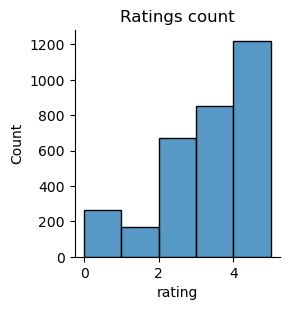

In [11]:
sns.displot(x = "rating", data = product, bins = 5, height=3)
plt.title('Ratings count')
plt.show()

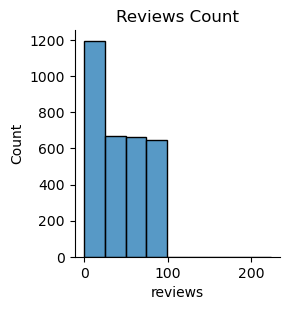

In [12]:
sns.displot(x = "reviews", data = product, height=3, bins = 9)
plt.title('Reviews Count')
plt.show()

In [13]:
product['brand'] = product['brand'].apply(lambda x: 'adidas' if 'adidas' in x.lower() else 'nike')

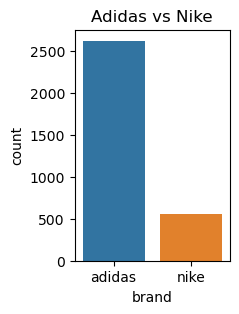

In [14]:
plt.figure(figsize=(2, 3))
sns.countplot(x = 'brand', data = product)
plt.title('Adidas vs Nike')
plt.show()

## Data Splitting

In [15]:
X = product.drop(columns=['brand'])
y = product['brand']
X.shape, y.shape

((3177, 5), (3177,))

## Under Sampling

In [16]:
from imblearn.under_sampling import RandomUnderSampler

sampler = RandomUnderSampler()
X_sampled, y_sampled = sampler.fit_resample(X, y)

X_sampled.shape, y_sampled.shape

((1104, 5), (1104,))

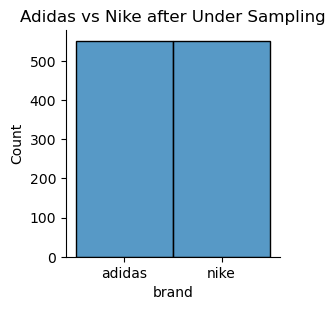

In [17]:
sns.displot(data = y_sampled, height=3)
plt.title('Adidas vs Nike after Under Sampling')
plt.show()

## Data Preprocessing

#### Analyzer

In [18]:
import string
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

def analyzer(text):
    text = ''.join([i for i in text if i not in string.punctuation])
    return ' '.join([ps.stem(i.lower()) for i in word_tokenize(text) if i not in stop_words and not i.isnumeric()])

#### Column Transformer

In [19]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

ids = np.sort(product['id'].unique())

ct = ColumnTransformer(transformers=[('min-max', MinMaxScaler(), ['rating', 'reviews']),
                                     ('encoder', OrdinalEncoder(categories=[ids]), ['id'])],
                       remainder='passthrough', sparse_threshold=0)
ct

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('min-max', MinMaxScaler(),
                                 ['rating', 'reviews']),
                                ('encoder',
                                 OrdinalEncoder(categories=[array(['130690-017', '133000-106', '280648', ..., 'S80662', 'S80807',
       'S82260'], dtype=object)]),
                                 ['id'])])

In [20]:
cv = TfidfVectorizer(analyzer=analyzer)
item_names_transformed = pd.DataFrame(cv.fit_transform(X_sampled['name']).toarray())
item_description_transformed = pd.DataFrame(cv.fit_transform(X_sampled['description']).toarray())

In [21]:
X_transformed = pd.DataFrame(ct.fit_transform(X_sampled))
X_transformed.drop(columns=[3, 4], inplace = True)
X_preprocessed = pd.concat([X_transformed, item_names_transformed, item_description_transformed], axis=1, ignore_index=True)

le = LabelEncoder()
y_preprocessed = le.fit_transform(y_sampled)

## Dimensionality Reduction

In [22]:
from sklearn.cross_decomposition import PLSRegression

pls = PLSRegression(n_components=10)
pls.fit(X_preprocessed, y_preprocessed)
X_reduced = pls.transform(X_preprocessed)

In [23]:
X_reduced

array([[ 1.90283597, -1.13351349, -0.55162612, ..., -0.30705087,
        -0.190559  , -0.23830969],
       [ 1.13643494,  1.13911497, -1.13944287, ..., -0.44029584,
         1.49452123,  1.99311193],
       [ 2.22780564, -0.10535753,  0.46766209, ..., -0.87031078,
        -0.50379508, -1.09626216],
       ...,
       [-1.22153572, -1.18553714, -1.30081418, ..., -1.51394496,
        -0.06938379, -2.49568826],
       [-3.70259005,  1.85335206, -0.74172034, ...,  0.68690334,
         0.83431286,  0.01417137],
       [-2.26135289,  0.33873228, -3.95522381, ..., -1.41347345,
        -1.04875595,  1.36431904]])

## Model Selection

In [24]:
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import BisectingKMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import Birch

In [25]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import rand_score, make_scorer

models = {
    'gaussian_mix' : GaussianMixture(), 
    'bayesian_mix' : BayesianGaussianMixture(), 
    'kmeans' : KMeans(), 
    'minibatch' : MiniBatchKMeans(), 
    'affinity_propa' : AffinityPropagation(), 
    'agglomerative' : AgglomerativeClustering(), 
    'bisecting' : BisectingKMeans(), 
    'dbscan' : DBSCAN(), 
    'birch' : Birch(),
}

#### Cross Validation Scores

In [26]:
for i in models.keys():
    scores = cross_val_score(models[i], X_reduced, y_preprocessed, cv = 5, scoring = lambda estimator, X, y: rand_score(y, estimator.fit_predict(X)) )
    print(f'{i}: {scores}, {scores.mean()}')

gaussian_mix: [1.         1.         0.49773756 1.         1.        ], 0.8995475113122172
bayesian_mix: [1.         1.         0.49773756 1.         1.        ], 0.8995475113122172
kmeans: [0.16166187 0.15071987 0.64352118 0.20448375 0.1898298 ], 0.2700432954099352
minibatch: [0.16803784 0.16997121 0.63126285 0.16672151 0.19684516], 0.26656771646296223
affinity_propa: [0.04689428 0.05248869 0.58107775 0.06462361 0.06185139], 0.16138714361115652
agglomerative: [0.97309749 0.50761004 0.95557384 0.96429453 0.64221669], 0.8085585164231416
bisecting: [0.1582065  0.13615796 0.65549157 0.14417935 0.15940224], 0.25068752359646795
dbscan: [1.         1.         0.49773756 1.         1.        ], 0.8995475113122172
birch: [0.48584944 0.4274784  0.85055533 0.61135335 0.50004151], 0.5750556078356239


## Model Building and Evaluation

In [27]:
model = AgglomerativeClustering()

y_pred = model.fit_predict(X_reduced)

print('Default model score: ', rand_score(y_preprocessed, y_pred))

Default model score:  0.9820318761743335


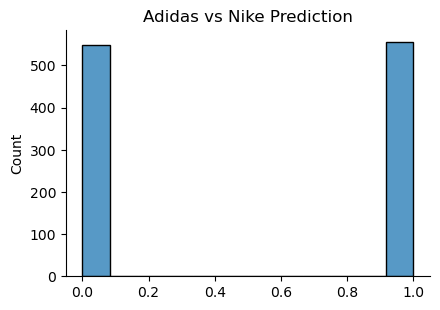

In [28]:
sns.displot(y_pred, height=3, aspect=1.5)
plt.title('Adidas vs Nike Prediction')
plt.show()